<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 9</strong></h2>

<h3><strong>Shor's Algorithm</strong></h3>

</div>

*In this session, we will learn why factoring large numbers can break RSA key encryption and how Shor's factoring algorithm works!*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Understand RSA key encryption
2. Apply Shor's algorithm to small numbers

<div/>

## Setup & Imports

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from quantumrings.toolkit.qiskit import QrBackendV2, QrSamplerV1
from QuantumRingsLib import QuantumRingsProvider
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np
from sympy import mod_inverse

# Provider & backend (toolkit)
provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=2)

# Helper Functions

Modular exponentiation: instead of computing x^e and then finding its equivalent mod N, we repeat e times multiplying by x and reducing mod N. This greatly reduces the computation time for large numbers.

In [2]:
def mod_exp(x,e,N):
    y = 1

    for i in range(e):
        y = (y*x)%N 

    return y

Construct a mapping from integers b to a^b mod N and print out a nice table if report is True.

In [3]:
def construct_mapping(N,a,report=False):

    inputs = list(range(N))
    table = {i: int((a**i)%N) for i in inputs}

    if report:
        print(f"{'b':>10} | {f'{a} ^ b (mod {N})':>10}")
        print("-" * 25)
        for i, o in table.items():
            print(f"{i:10} | {o:10}")

    return table

One of the key aspects of Shor's algorithm is modular exponentiation. For our learning purposes, we will not construct the controlled unitaries $U_{a^{2^j}}$. Instead, we can just create a unitary which applies the final intended effect. Of course this is "cheating" because we can read off what r is from the mapping we use to constuct our unitary. But it allows us to get a feel for how Shor's algorithm works without getting deep into the weeds of quantum modular arithmetic.

In [4]:
def quasi_modular_exponentiation(mapping, num_source):

    qs = QuantumRegister(num_source, 'source')
    qt = QuantumRegister(num_source, 'target')
    qc = QuantumCircuit(qs,qt)

    for b, out in mapping.items():

        if b > 2**num_source: continue

        # binary in and out
        b_binary = bin(b)[2:].zfill(num_source)
        out_binary = bin(out)[2:].zfill(num_source)

        # flip the input binary string to the all 1's string
        for i, bit in enumerate(b_binary):
            if bit == '0':
                qc.x(qs[i])

        # flip every qubit in the target register where the output binary string is 1
        for i, bit in enumerate(out_binary):
            if bit == '1':
                qc.mcx(qs,qt[i])

        # flip the all 1's string back to the input binary string
        for i, bit in enumerate(b_binary):
            if bit == '0':
                qc.x(qs[i])

    return qc

Function to convert distribution of measured integers ($k$) to fractions ($k/2^n$). You can guess an $r$ value to see if it aligns well with the data.

In [5]:
def plot_fractions(counts, guess_r=None):

    fraction = []
    prob = []
    
    modified_counts = {}
    for k, val in counts.items():
    
        if k !=0:
            gcd = np.gcd(k,2**num_source)
            if k/gcd < N:
                if 2**num_source/gcd < N:
                    modified_counts[f'{int(k/gcd)}/{int(2**num_source/gcd)}'] = val
    
                    fraction.append(k/2**num_source)
                    prob.append(val)
        else:
            fraction.append(0)
            prob.append(val)

    plt.bar(fraction,prob, align='center', width=0.05)
    
    if guess_r is not None:
        for i in range(guess_r):
            if i==0:
                plt.axvline(i*1/guess_r, color='k', lw=1, label=f'Multiples of 1/{guess_r}')
            else:
                plt.axvline(i*1/guess_r, color='k', lw=1)
    
    plt.xlabel('$k/2^{n}$')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# 1. RSA Key Encryption

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

The security of RSA key encryption relies on the fact that large numbers are difficult to factor into a product of primes. It is easy, however, to find very large primes with hundreds of digits. We can pick two $p$ and $q$ and define $N=pq$. If I tell you $N$, and you are equipped with only a classical computer, it is virtually impossible for you to find $p$ and $q$.

In the RSA scheme, there is a public key $\{N,e\}$ and a private key $\{N,d\}$. Alice uses $\{N,e\}$ to encrypt her message, and Bob uses $\{N,d\}$ to decrypt. In the absence of knowing $d$, an eavesdropper is powerless to decrypt the message.

The steps of RSA key generation are as follows:
1. Pick two primes $p$ and $q$ and define $N=pq$.
2. Compute Carmichael's totient function $\lambda(N) = \text{lcm}(p-1,q-1)$.
3. Choose $1 < e < \lambda(N)$.
4. Compute $d \equiv e^{-1} ~\text{mod}~ \lambda(N)$. (This means $de \equiv 1 ~\text{mod}~ \lambda(N)$)

Then to encrypt data $D$, Alice performs modular exponentiation:
$$ E \equiv D^e  ~\text{mod}~ N$$

To decrypt the data, Bob performs modular exponentiation:
$$ E^d \equiv D^{ed} \equiv D ~\text{mod}~ N$$

Let's try it out with some small numbers.

</div>

In [6]:
# Pick two large primes 
# You can find a ton here: https://en.wikipedia.org/wiki/List_of_prime_numbers
p = 1999
q = 4457

In [8]:
N = p*q
lam = np.lcm(p-1,q-1)

print('N =', N)
print('\u03BB(N) =', lam)

N = 8909543
λ(N) = 4451544


In [10]:
# Find an e with 1<e<lambda and e coprime to lambda 
# In other words, gcd(e,lambda) = 1

for _ in range(100):
    
    # pick a random integer between 1 and lambda-1
    e = np.random.randint(1,lam)

    # if we find an e coprime with lambda, stop looking
    if np.gcd(e,lam)==1:
        break

print('e =', e)

e = 3461533


In [11]:
# d is the modular inverse of e

d = mod_inverse(e,lam)

print('d =', d)

d = 2372125


In [12]:
message = 'hi'

# turn message into an integer using ASCII keys
M = ''
for letter in message:
    M += str(ord(letter))
M = int(M)

print("Message:", message, '=', M)

Message: hi = 104105


In [16]:
E = mod_exp(M,e,N)
print("Encoded message:", E)

Encoded message: 105572


In [17]:
D = mod_exp(E,d,N)
print("Decoded message:", D)

Decoded message: 104105


<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Explore the following questions:

**A)** Play around with other values of $p$ and $q$ and other messages.

**B)** What happens if the message is a larger number than $N$? Does this encryption scheme still work? Why or why not?

**C)** Why is it a problem if an eavesdropper can factor $N$ into $p$ and $q$?

<div/>

# 2. Shor's Algorithm

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

Shor's algorithm is an efficient way to factor a number $N$ into a product of primes. The best classical algorithm is super-polynomial time and Shor's algorithm is $\mathcal{O}((\log{N})^3)$, an exponential speed-up.

Shor's algorithm is just a special case of Quantum Phase Estimation. In the previous epsiode/notebook, we explored QPE with a unitary with only one eigenvalue: $e^{2\pi i \theta}$. At the end of the QPE algorithm, the register is an n-bit approximation of $\theta$. For Shor's algorithm, the unitary has $r$ different eigenvalues: $e^{2\pi i k/r}$ for $0 \leq k < r$. At the end of the algorithm, we expect to measure an n-bit approximation of one of $\{0/r,1/r,...,(r-1)/r\}$.

The hardest part of Shor's algorithm (and the complexity bottleneck) is the controlled unitaries which perform the modular exponentiation. For the purposes of this lesson, we will not actually construct these controlled unitaries, but instead employ a mapping unitary which achieves the same effective modular exponentiation. The goal in this notebook is to build an intuition for how Shor's works without getting deep into quantum modular arithmetic.

Let's use Shor's algorithm to factorize some small numbers!

</div>

## Factoring 15

In [19]:
# Pick an a for our N
N = 15
a = 7

We want to find the period $r$ of the function $f(b) = a^b ~\text{mod}~N$. Let's take a look at this function.

In [20]:
mapping = construct_mapping(N, a, report = True)

         b | 7 ^ b (mod 15)
-------------------------
         0 |          1
         1 |          7
         2 |          4
         3 |         13
         4 |          1
         5 |          7
         6 |          4
         7 |         13
         8 |          1
         9 |          7
        10 |          4
        11 |         13
        12 |          1
        13 |          7
        14 |          4


We can see what $r$ is from the table above. We can run Shor's algorithm with $n=4$ qubits, since $15 < 2^4$. We expect to see measurement results at multiples of $2^n/r = 16/4 = 4$, i.e. $0,4,8,12,...$

In [21]:
num_source = 4
num_qubits = 2*num_source

qs = QuantumRegister(num_source, 'source')
qt = QuantumRegister(num_source, 'target')
cr = ClassicalRegister(num_source)

qc = QuantumCircuit(qs,qt,cr, name='QSS9.1.shor_15')

# create equal superposition state in source register
qc.h(qs)
# apply modular exponentiation unitary
qc.compose(quasi_modular_exponentiation(mapping,num_source).to_gate(), inplace=True)
# perform inverse QFT on source register
qc.compose(QFT(num_source, inverse=True, do_swaps = False), inplace=True)
qc.barrier()

# measure source register
qc.measure(qs,cr)
qc.draw()

┌───┐┌──────────────┐┌──────────┐ ░ ┌─┐         
source_0: ┤ H ├┤0             ├┤0         ├─░─┤M├─────────
          ├───┤│              ││          │ ░ └╥┘┌─┐      
source_1: ┤ H ├┤1             ├┤1         ├─░──╫─┤M├──────
          ├───┤│              ││  IQFT_dg │ ░  ║ └╥┘┌─┐   
source_2: ┤ H ├┤2             ├┤2         ├─░──╫──╫─┤M├───
          ├───┤│              ││          │ ░  ║  ║ └╥┘┌─┐
source_3: ┤ H ├┤3             ├┤3         ├─░──╫──╫──╫─┤M├
          └───┘│  circuit-158 │└──────────┘ ░  ║  ║  ║ └╥┘
target_0: ─────┤4             ├─────────────░──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║ 
target_1: ─────┤5             ├─────────────░──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║ 
target_2: ─────┤6             ├─────────────░──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║ 
target_3: ─────┤7             ├─────────────░──╫──╫──╫──╫─
               └──────────────┘             ░  ║  ║  ║  ║ 
    c0: 4/═════════════════════════════════════╩══╩══╩══╩═
                                               0  1  2  3

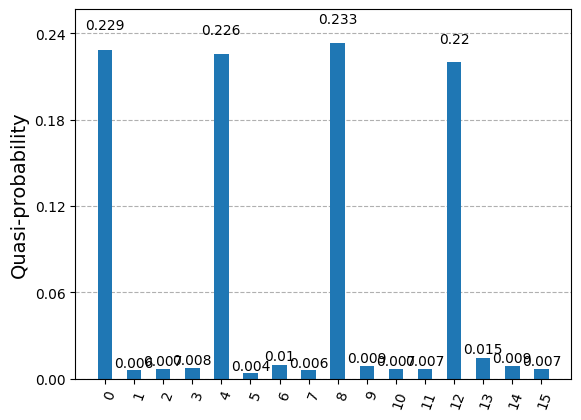

In [22]:
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)

In [24]:
# Determine r from the smallest non-zero high-probability measurement result 
k = 4
r = 2**num_source / k
print(r)

4.0


We may proceed because $r$ is even. If $r$ was odd, we would need to pick a new $a$ and try again. Now we need to do some classical post-processing. We know that $\gcd (N, a^{r/2}+1 )$ will be a factor of $N$. If we are unlucky, it will be the case that $a^{r/2}+1 = N$ and $\gcd (N, a^{r/2}+1 )= N$, in which case we have learned nothing. But if $a^{r/2}+1 \neq N$, we will learn a nontrivial factor of $N$!

In [25]:
f1 = np.gcd(N, int(a**(r/2))+1)
f2 = int(N/f1)

print(f'Two factors of N are {f1} and {f2}.')

Two factors of N are 5 and 3.


## Factoring 21

In [26]:
# Pick an a for our N
N = 21
a = 17

We want to find the period $r$ of the function $f(b) = a^b ~\text{mod}~N$. Let's take a look at this function.

In [27]:
mapping = construct_mapping(N,a, report=True)

         b | 17 ^ b (mod 21)
-------------------------
         0 |          1
         1 |         17
         2 |         16
         3 |         20
         4 |          4
         5 |          5
         6 |          1
         7 |         17
         8 |         16
         9 |         20
        10 |          4
        11 |          5
        12 |          1
        13 |         17
        14 |         16
        15 |         20
        16 |          4
        17 |          5
        18 |          1
        19 |         17
        20 |         16


In [28]:
num_source = 5
num_qubits = 2*num_source

qs = QuantumRegister(num_source, 'source')
qt = QuantumRegister(num_source, 'target')
cr = ClassicalRegister(num_source)

qc = QuantumCircuit(qs,qt,cr, name='QSS9.2.shor_21')

# create equal superposition state in source register
qc.h(qs)

# apply modular exponentiation unitary
qc.compose(quasi_modular_exponentiation(mapping, num_source).to_gate(),inplace=True)

# perform inverse QFT on source register
qc.compose(QFT(num_source,inverse=True, do_swaps=False),inplace=True)

qc.barrier()

# measure source register
qc.measure(qs,cr)
qc.draw()

┌───┐┌──────────────┐┌──────────┐ ░ ┌─┐            
source_0: ┤ H ├┤0             ├┤0         ├─░─┤M├────────────
          ├───┤│              ││          │ ░ └╥┘┌─┐         
source_1: ┤ H ├┤1             ├┤1         ├─░──╫─┤M├─────────
          ├───┤│              ││          │ ░  ║ └╥┘┌─┐      
source_2: ┤ H ├┤2             ├┤2 IQFT_dg ├─░──╫──╫─┤M├──────
          ├───┤│              ││          │ ░  ║  ║ └╥┘┌─┐   
source_3: ┤ H ├┤3             ├┤3         ├─░──╫──╫──╫─┤M├───
          ├───┤│              ││          │ ░  ║  ║  ║ └╥┘┌─┐
source_4: ┤ H ├┤4             ├┤4         ├─░──╫──╫──╫──╫─┤M├
          └───┘│  circuit-196 │└──────────┘ ░  ║  ║  ║  ║ └╥┘
target_0: ─────┤5             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_1: ─────┤6             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_2: ─────┤7             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_3: ─────┤8             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_4: ─────┤9             ├─────────────░──╫──╫──╫──╫──╫─
               └──────────────┘             ░  ║  ║  ║  ║  ║ 
    c1: 5/═════════════════════════════════════╩══╩══╩══╩══╩═
                                               0  1  2  3  4

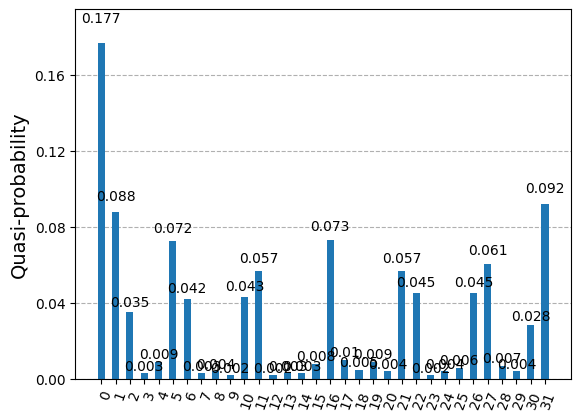

In [29]:
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)

We can use the function below to convert the measured values $k$ to fractions $k/2^n$. We expect $k/2^n$ to be multiples of $1/r$. Guess different values for $r$ and see if the data aligns well.

/tmp/ipykernel_4770/3673750174.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


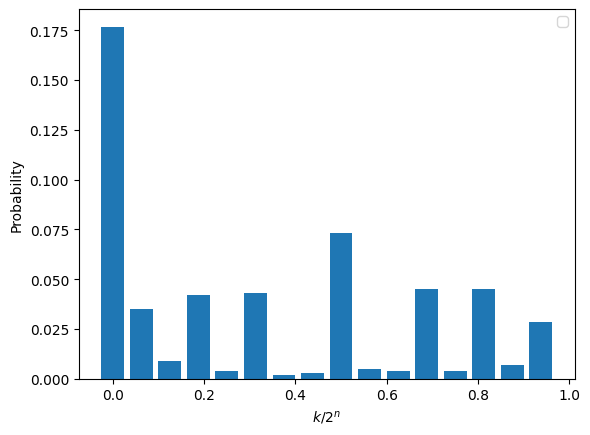

In [30]:
plot_fractions(counts, guess_r=None)

In [31]:
r = 6
f1 = np.gcd(N, int(a**(r/2))+1)
f2 = int(N/f1)

print(f'Two factors of N are {f1} and {f2}.')

Two factors of N are 21 and 1.


### Attempt 2:

Oh no! That choice of $a$ didn't work out. Try again.

In [32]:
# Pick an a for our N
N = 21
a = 11

We want to find the period $r$ of the function $f(b) = a^b ~\text{mod}~N$. Let's take a look at this function.

In [33]:
mapping = construct_mapping(N,a, report=True)

         b | 11 ^ b (mod 21)
-------------------------
         0 |          1
         1 |         11
         2 |         16
         3 |          8
         4 |          4
         5 |          2
         6 |          1
         7 |         11
         8 |         16
         9 |          8
        10 |          4
        11 |          2
        12 |          1
        13 |         11
        14 |         16
        15 |          8
        16 |          4
        17 |          2
        18 |          1
        19 |         11
        20 |         16


In [34]:
num_source = 5
num_qubits = 2*num_source

qs = QuantumRegister(num_source, 'source')
qt = QuantumRegister(num_source, 'target')
cr = ClassicalRegister(num_source)

qc = QuantumCircuit(qs,qt,cr, name='QSS9.3.shor_21_2')

# create equal superposition state in source register
qc.h(qs)

# apply modular exponentiation unitary
qc.compose(quasi_modular_exponentiation(mapping, num_source).to_gate(),inplace=True)

# perform inverse QFT on source register
qc.compose(QFT(num_source,inverse=True, do_swaps=False),inplace=True)

qc.barrier()

# measure source register
qc.measure(qs,cr)
qc.draw()

┌───┐┌──────────────┐┌──────────┐ ░ ┌─┐            
source_0: ┤ H ├┤0             ├┤0         ├─░─┤M├────────────
          ├───┤│              ││          │ ░ └╥┘┌─┐         
source_1: ┤ H ├┤1             ├┤1         ├─░──╫─┤M├─────────
          ├───┤│              ││          │ ░  ║ └╥┘┌─┐      
source_2: ┤ H ├┤2             ├┤2 IQFT_dg ├─░──╫──╫─┤M├──────
          ├───┤│              ││          │ ░  ║  ║ └╥┘┌─┐   
source_3: ┤ H ├┤3             ├┤3         ├─░──╫──╫──╫─┤M├───
          ├───┤│              ││          │ ░  ║  ║  ║ └╥┘┌─┐
source_4: ┤ H ├┤4             ├┤4         ├─░──╫──╫──╫──╫─┤M├
          └───┘│  circuit-236 │└──────────┘ ░  ║  ║  ║  ║ └╥┘
target_0: ─────┤5             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_1: ─────┤6             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_2: ─────┤7             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_3: ─────┤8             ├─────────────░──╫──╫──╫──╫──╫─
               │              │             ░  ║  ║  ║  ║  ║ 
target_4: ─────┤9             ├─────────────░──╫──╫──╫──╫──╫─
               └──────────────┘             ░  ║  ║  ║  ║  ║ 
    c2: 5/═════════════════════════════════════╩══╩══╩══╩══╩═
                                               0  1  2  3  4

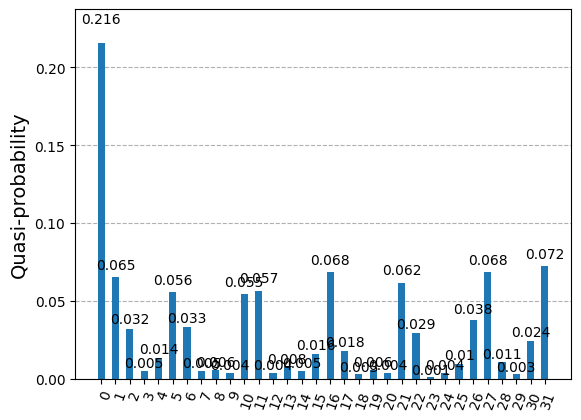

In [35]:
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)

We can use the function below to convert the measured values $k$ to fractions $k/2^n$. We expect $k/2^n$ to be multiples of $1/r$. Guess different values for $r$ and see if the data aligns well.

In [ ]:
plot_fractions(counts, guess_r=None)

In [ ]:
r = 6
f1 = np.gcd(N, int(a**(r/2))+1)
f2 = int(N/f1)

print(f'Two factors of N are {f1} and {f2}.')

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Use Shor's Algorithm to factor 33. How many qubits do you need in each register to perform Shor's algorithm?

First try using $a=4$. Does it work? Why or why not?

Try again with other numbers. Which values of $a$ work?

<div/>

In [ ]:
# your code here